In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Initializing and Coordinate Checks

I've packed up some code from the previous notebooks into functions and placed them in `tide_utils.py`, for code hygiene. Let's import that, and then load in the data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits
from pixell import enmap

import tide_utils

/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in log10
/home/zequnl/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log10


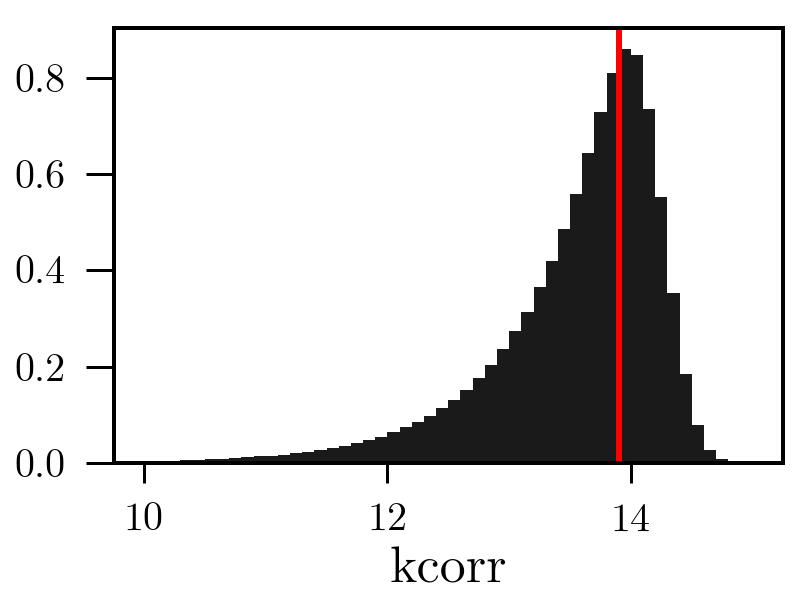

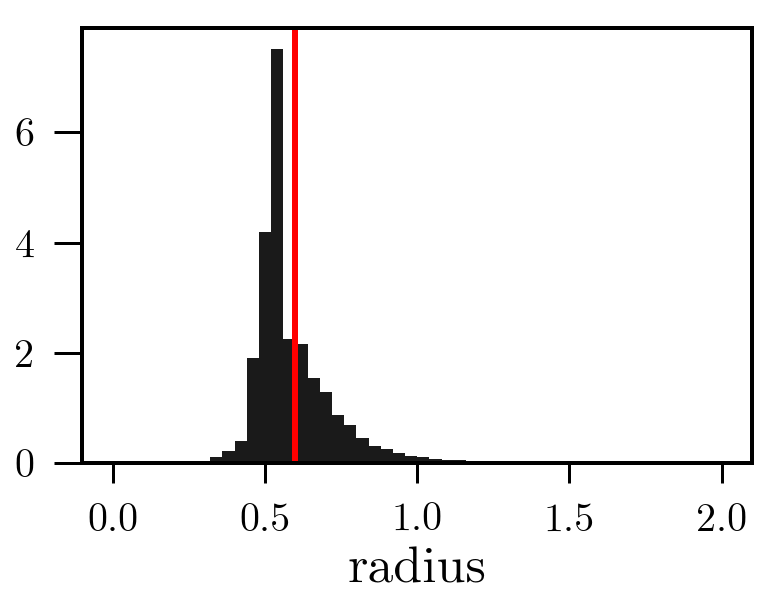

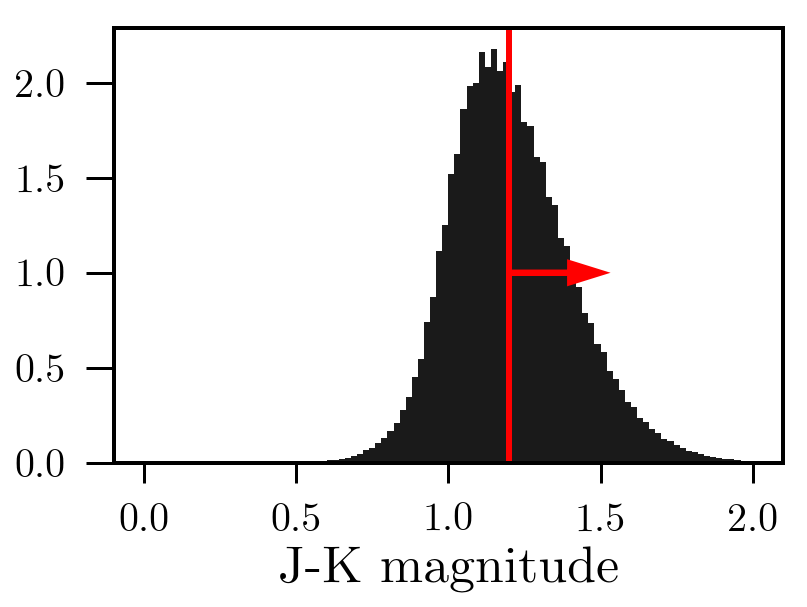

<Figure size 432x288 with 0 Axes>

In [104]:
tidal, galaxy_data, mask = tide_utils.load_files(
    tidal_filename="../outputs/out_2MASS_XSC_EQ/tidal_sm2.0.fits", 
    galaxy_cat_filename="../data/2MASS_XSC.fits", 
    mask_filename="../outputs/out_2MASS_XSC_EQ/mask.fits",
    verbose=False)

npix = len(mask)
nside = hp.get_nside(mask)
jk_color_cut = 1.2
radius_cut = 0.6

# masking and cuts
gal_healpix_pixel = hp.ang2pix( 
    nside=nside, 
    phi=galaxy_data['dec'], theta=galaxy_data['ra'], lonlat=True )
ellip = (1-galaxy_data['j_ba'])
cut = np.logical_and(galaxy_data['kcorr_schlegel'] < 13.6, 
                     mask[gal_healpix_pixel] > 0.0)
cut = np.logical_and(cut, ellip > 0.2)
cut = np.logical_and(cut, galaxy_data['r_3sig'] > radius_cut)
cut = np.logical_and(cut, galaxy_data['j_m_k20fe'] > -12345)
# cut = np.logical_and(cut, galaxy_data['j_m_k20fe'] - galaxy_data['k_m_k20fe'] > jk_color_cut)

plt.figure()
plt.hist( galaxy_data['kcorr_schlegel'], bins=50, density=True, range=(10,15))
plt.axvline(13.9, color="red")
plt.xlabel("kcorr")

plt.figure()
plt.hist( np.log10( galaxy_data['r_3sig'] ), range=(0,2), bins=50, density=True )
plt.axvline(radius_cut, color="red")
plt.xlabel('radius')

plt.figure()
plt.hist( galaxy_data['j_m_k20fe'] - galaxy_data['k_m_k20fe'], bins=100, range=(0,2) , density=True);
plt.xlabel("J-K magnitude")
plt.arrow( jk_color_cut, 1, 0.2, 0, color="red", head_width=0.1, head_length=0.1)
plt.axvline(jk_color_cut, color="red")

# if a source very red, then luminosity J (bluer band) << K (redder band)
# because magnitudes are backwards, m_J >> m_K
# thus m_J - m_K >> 0
# thus redder sources are more positive values of [J-K]


plt.figure()

galaxy_data = galaxy_data[ cut ]
ngal = len(galaxy_data)

## Basic Calculations
We compute the principal eigenvectors and eigenvalues, and compute the ellipticity vector array for the galaxies as well.

In [105]:
# calculate stuff for tidal field
peigval, peigvec, shorteval, shortevec = tide_utils.compute_eig(
    t11= tidal['t22'],
    t12= tidal['t12'], # NOTE: SWAPPED AROUND TO MATCH SPHERICAL COORDINATES
    t22= tidal['t11'])

# NOTE: uncomment to swap x and y eigenvector components
# peigvec_copy = peigvec.copy()
# peigvec[:,0] = peigvec_copy[:,1]
# peigvec[:,1] = peigvec_copy[:,0]

th, ph = hp.pix2ang(nside,np.arange(npix))

# recompute stuff for galaxies
phi_x = np.cos((90-galaxy_data['j_phi']) * np.pi / 180)
phi_y = -np.sin((90-galaxy_data['j_phi']) * np.pi / 180)
gal_ellip = np.vstack( [phi_x,phi_y] )
gal_healpix_pixel = hp.ang2pix( nside=nside, 
    phi=galaxy_data['dec'], theta=galaxy_data['ra'], lonlat=True )
gal_tidal_x = peigvec[gal_healpix_pixel,0]
gal_tidal_y = peigvec[gal_healpix_pixel,1]

## Coordinate Checks

We plot the tidal field and an example row of galaxies, to demonstrate that things seem to work.

-0.00939373908765912 0.0034289453120435187
-0.00953516036466219 0.0030134227748816185
-0.00912218556152664 0.004097039245732814


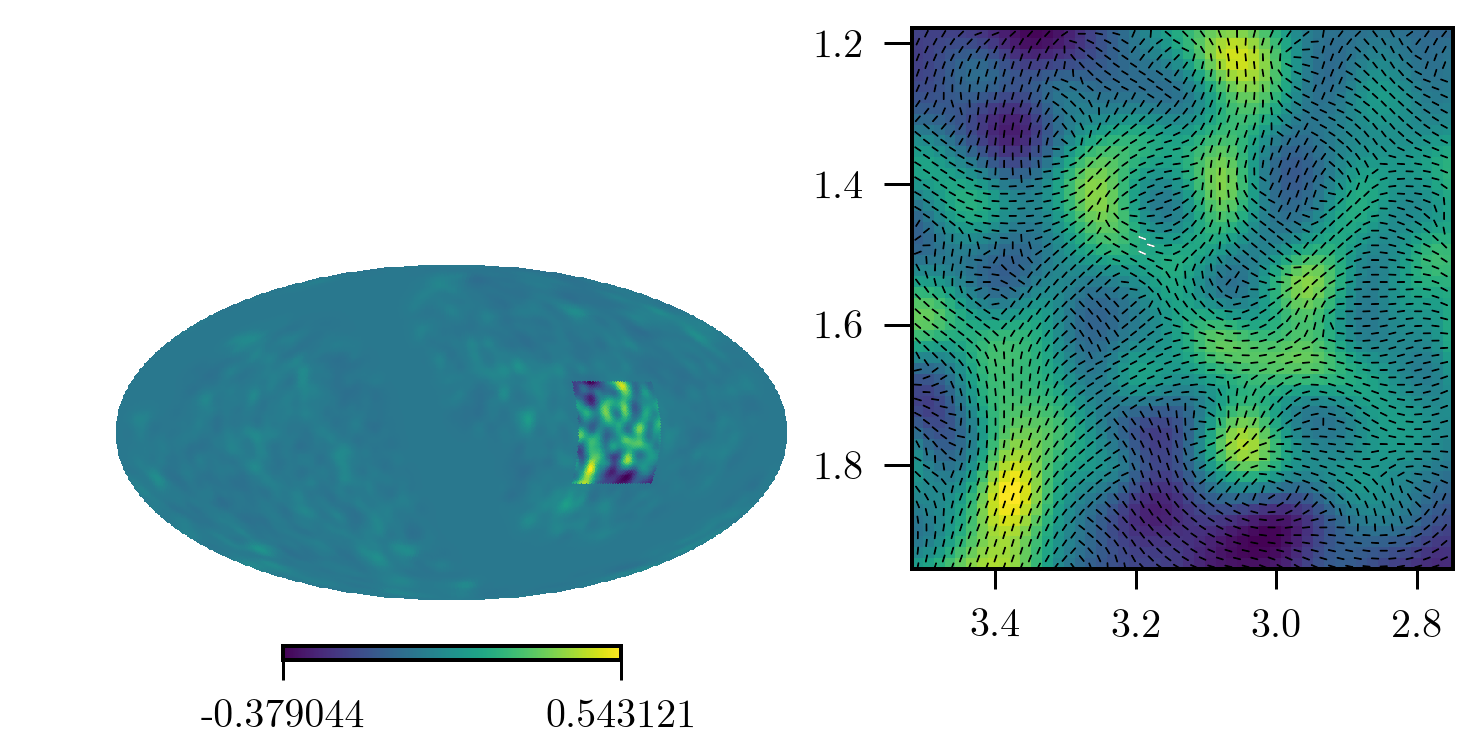

In [106]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,8), 
                               gridspec_kw={'width_ratios':[1,0.8]})
plt.sca(ax1)

cp = np.pi
bounding_box = (cp - np.pi/8, cp + np.pi/8, 
                np.pi/2-np.pi/8, np.pi/2+np.pi/8)
smoothed_cutout, ph_grid, th_grid = tide_utils.get_cutout_from_hp(
    tidal['den'], bbox=bounding_box, 
    debug=True, hold=True, rot=(-90,0,0), title="") 
# NOTE: we rotate the mollweide by -90 in phi for visual aid, 
# since it would be on the edge otherwise.

plt.sca(ax2)
plt.imshow(smoothed_cutout.T,
          extent=( np.min(ph_grid), np.max(ph_grid), 
                  np.max(th_grid), np.min(th_grid)) )
tide_utils.plot_vectorfield(ax2, bounding_box, nside, shortevec)
tide_utils.plot_vectorfield(ax2, 
                            (3.17, 3.2, 1.47, 1.5),
                            nside, shortevec, color="white", debug=True)

plt.xlim( np.max(ph_grid), np.min(ph_grid) )
plt.ylim( np.max(th_grid), np.min(th_grid) );

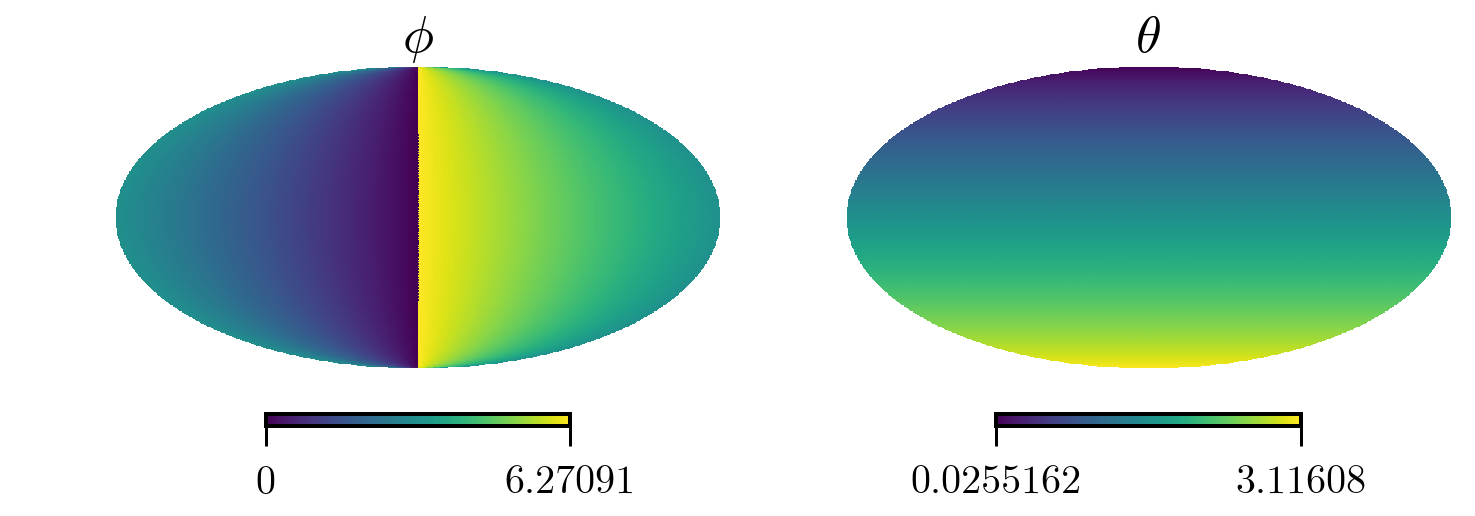

In [107]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,8))
plt.sca(ax1)
hp.mollview( ph, hold=True, title=r"$\phi$" )
plt.sca(ax2)
hp.mollview( th, hold=True, title=r"$\theta$" )

In [108]:
# tide_utils.plot_row([161, 215, 242], # chosen from magnitude cut
#                     galaxy_data,
#                     phi_x,
#                     phi_y, debug=True) 

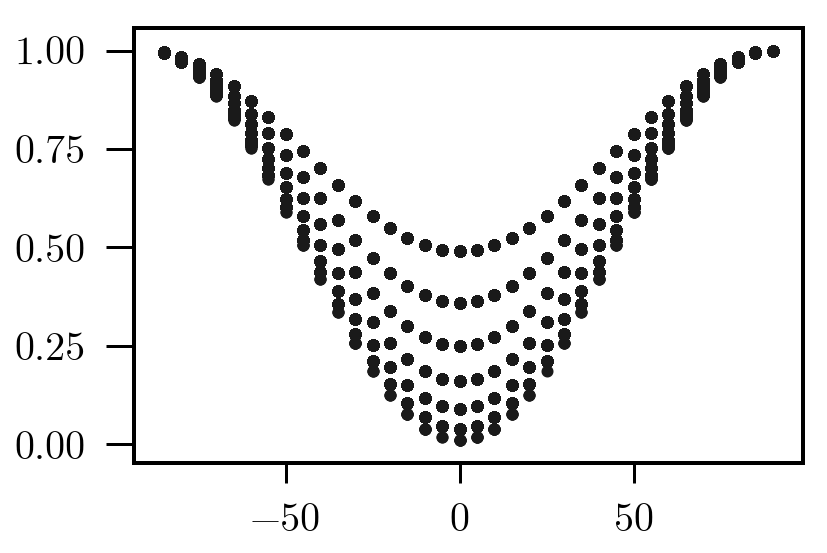

In [109]:
J1 = tide_utils.compute_galaxy_inertia_tensor(
    polar_angle=(90-galaxy_data['j_phi']) * np.pi / 180,
    ba=galaxy_data['j_ba'], r=1)
plt.scatter( galaxy_data['j_phi'], 
            J1[:,0,0] )

j_eigv, j_eigvec = np.linalg.eig(J1)
long_eig_ind = np.argmax(np.abs(j_eigv), axis=1)
j_lam = np.array( [j_eigv[i,~long_eig_ind[i]] for i in range(ngal)] )
j_x = np.array( [j_eigvec[i,long_eig_ind[i],0] for i in range(ngal)] )
j_y = np.array( [j_eigvec[i,long_eig_ind[i],1] for i in range(ngal)] )

for i in range(ngal):
    if j_y[i] > 0.0:
        j_y[i] *= -1
        j_x[i] *= -1

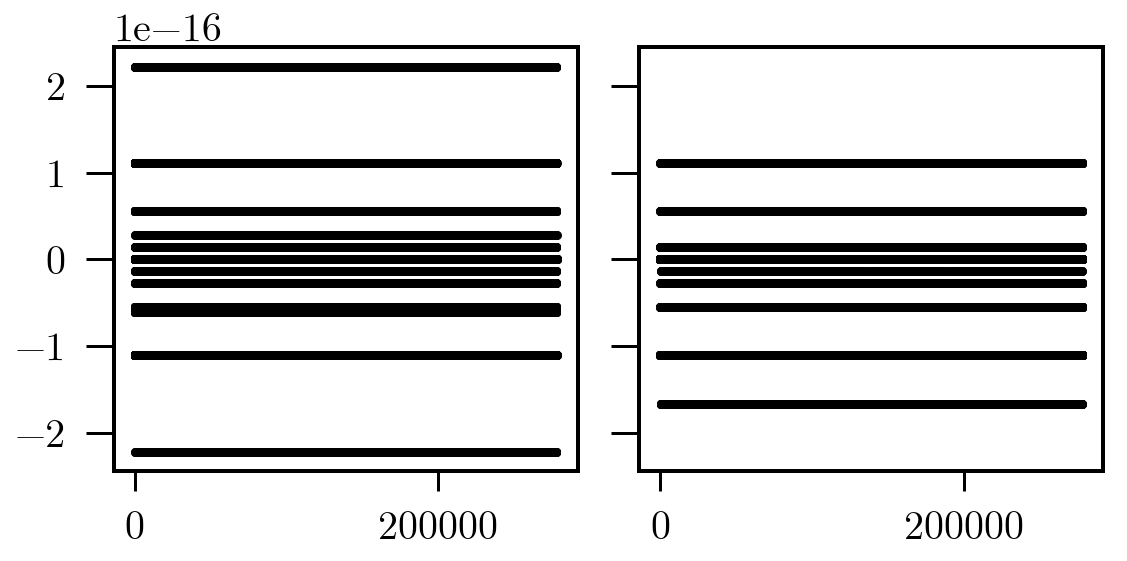

In [110]:
fig, axes = plt.subplots(1,2,figsize=(8,4), sharey=True)
axes[0].plot( j_x - phi_x, 'k.' )
axes[1].plot( j_y - phi_y, 'k.' )
plt.tight_layout()

We ensure that both tangent planes correctly in the direction of $d\phi$ and $d\theta$.

# Zero Lag Detection Methods

## Method 1: eigenvector cosines

We make a few histograms of the absolute value of the magnitude of the dot product.

## Method 2 - overall amplitude

We consider the spin-2 component. 

Text(0.5, 0, 'galaxy data angle')

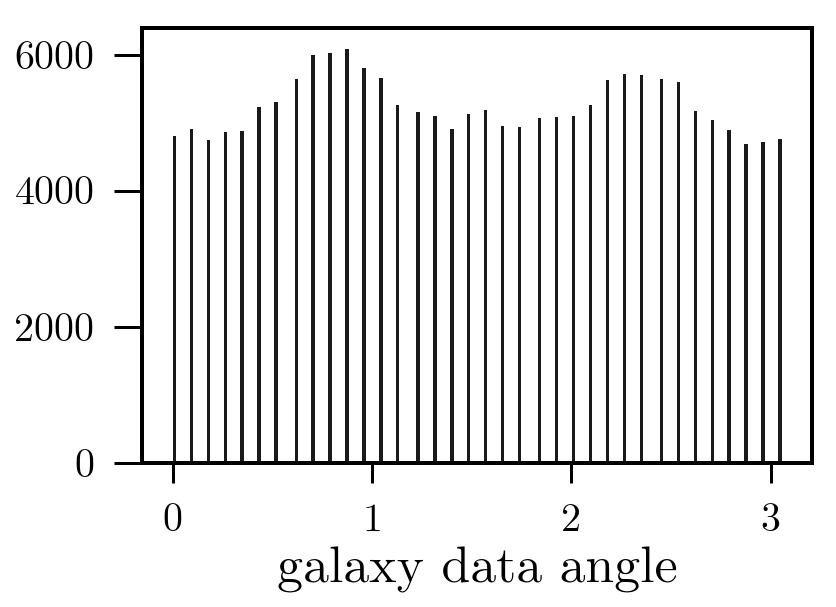

In [111]:
fig, ax = plt.subplots(facecolor='w')
plt.hist(data_polar, bins=180);
plt.xlabel('galaxy data angle')

In [112]:
data_polar = (90-galaxy_data['j_phi']) * np.pi / 180
J = tide_utils.compute_galaxy_inertia_tensor(
    polar_angle=data_polar,
    ba=galaxy_data['j_ba'],
    r=galaxy_data["r_3sig"] )

# now generate realizations by spinning the galaxy angles
n_real = 4000
J_r = np.array( [tide_utils.compute_galaxy_inertia_tensor(
    polar_angle= np.random.choice(data_polar, size=ngal, replace=True) ,
    ba=galaxy_data['j_ba'],
    r=galaxy_data["r_3sig"] )
                 for i in range(n_real)] )

In [113]:
I2g = np.array( [ J[:,0,0] - J[:,1,1], 
                 J[:,0,1] ] )
I2g_r = np.array([J_r[:,:,0,0] - J_r[:,:,1,1],
                 J_r[:,:,0,1]])

T2g = np.array( [ (tidal['t22'] - tidal['t11'])[gal_healpix_pixel],
                 (tidal['t12'])[gal_healpix_pixel] ] )

$ \sum_g T_g \cdot I_g $ 

In [114]:
alpha2_r = np.array( [ np.sum( np.abs(I2g_r[0,i,:] * T2g[0,:] 
                           + I2g_r[1,i,:] * T2g[1,:]) )
     for i in range(n_real) ] )

alpha2_g = np.sum( np.abs(I2g[0,:] * T2g[0,:] 
                  + I2g[1,:] * T2g[1,:]) )

In [115]:
norm =  np.sum(np.abs(T2g[0,:] * T2g[0,:] + T2g[1,:] * T2g[1,:]))

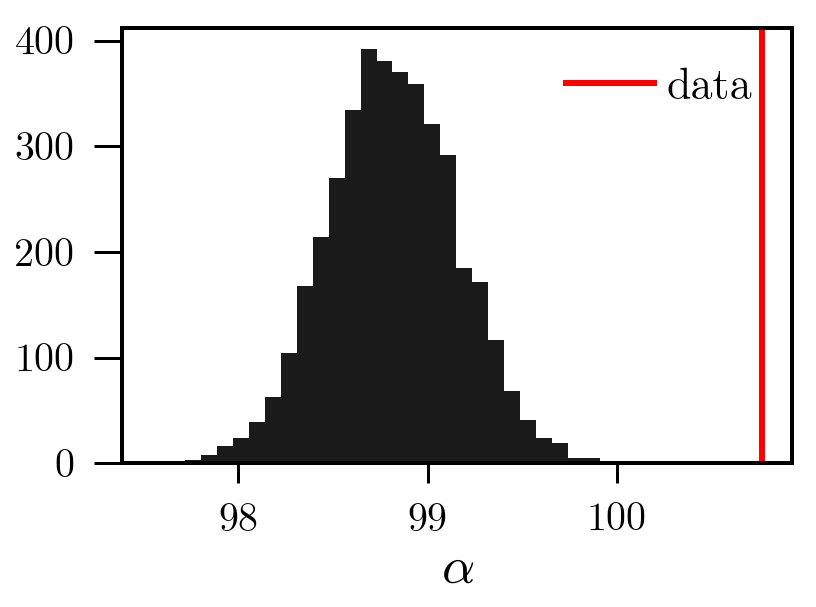

In [116]:
fig, ax = plt.subplots(facecolor='w')
plt.hist( alpha2_r / norm , bins=30);
plt.axvline(alpha2_g / norm, color="red", label="data")
plt.xlabel(r"$\alpha$")
plt.legend()

In [117]:
# nbins = 3
# counts_arr = np.zeros((n_real, nbins))

# for i in range(n_real):
#     reali = np.abs(I2g_r[0,i,:] * T2g[0,:] 
#                            + I2g_r[1,i,:] * T2g[1,:])
#     countsr, bins = np.histogram( reali, range=(0,5.0),
#                                 bins=nbins );
#     counts_arr[i,:] = countsr
    
# means =  np.mean( counts_arr, axis=0 )
# abs_dot = np.abs(I2g[0,:] * T2g[0,:] + I2g[1,:] * T2g[1,:])
# countsg, bins = np.histogram( abs_dot, bins=nbins, range=(0,5.0) );

# bin_midpoints = (bins[1:] + bins[:-1])/2
# plt.errorbar( bin_midpoints,  countsg / means,
#             yerr=np.std( counts_arr, axis=0 ) / means, fmt='ko')
# plt.xlim(0,5.0)
# plt.xlabel(r"dot product of (11 - 22, 12)")
# plt.ylabel(r"density data / random")
# plt.axhline(1.0, ls="dashed")

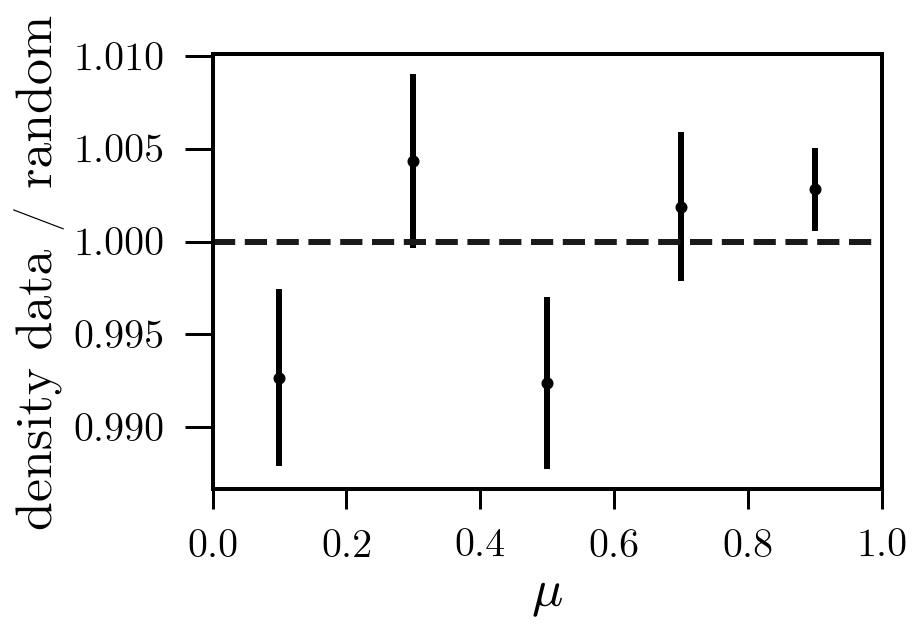

In [118]:
def generate_realization():
    ngal = len(galaxy_data)
    rand_theta = np.random.choice(data_polar, size=ngal, replace=True)
    rand_phi_x = -np.cos(rand_theta)
    rand_phi_y = np.sin(rand_theta)
    rand_dot = np.abs(gal_tidal_x * rand_phi_x + gal_tidal_y * rand_phi_y)
    return rand_dot

nrealizations = 1000
realizations = np.array( [generate_realization() for i in range(nrealizations)] )

nbins = 5
counts_arr = np.zeros((nrealizations, nbins))

for i in range(nrealizations):
    countsr, bins = np.histogram( realizations[i,:], range=(0,1),
                                bins=nbins, density=False );
    counts_arr[i,:] = countsr
    
means =  np.mean( counts_arr, axis=0 )
abs_dot = np.abs(gal_tidal_x * phi_x + gal_tidal_y * phi_y)
countsg, bins = np.histogram( abs_dot, bins=nbins, density=False, range=(0,1) );

bin_midpoints = (bins[1:] + bins[:-1])/2
plt.errorbar( bin_midpoints,  countsg / means,
            yerr=np.std( counts_arr, axis=0 ) / means, fmt='ko')
plt.xlim(0,1)
plt.xlabel(r"$\mu$")
plt.ylabel(r"density data / random")
plt.axhline(1.0, ls="dashed")

# FLIPPED

(array([0.64774523, 0.66935893, 0.73196848, 0.89516004, 2.05576731]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 1 Patch objects>)

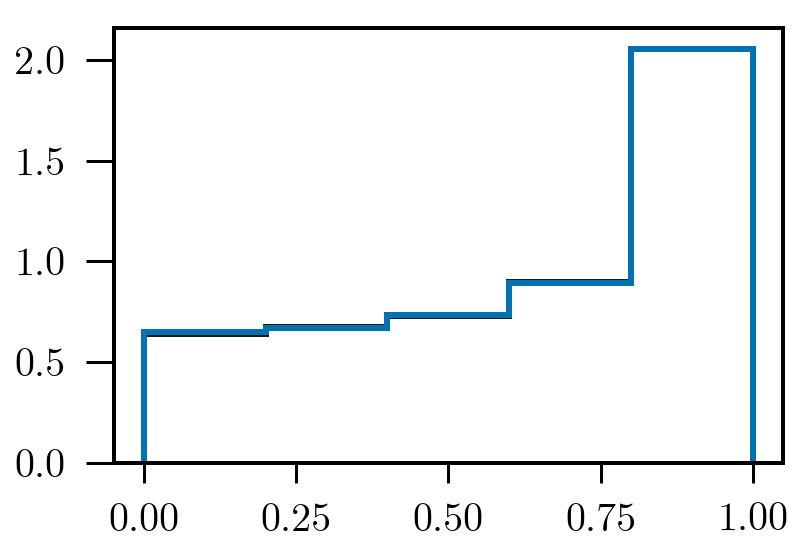

In [119]:
plt.hist( abs_dot, bins=nbins, density=True, range=(0,1), histtype="step" )
plt.hist( realizations[0,:], bins=nbins, density=True, range=(0,1), histtype="step" )

# Two Point Statistics

In [120]:
# plt.hist( galaxy_data['j_phi'], bins=180, label=r"j_phi", density=True );
# plt.legend()
# plt.ylim(0,0.04)